In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/comment-category-prediction-challenge/Sample.csv
/kaggle/input/comment-category-prediction-challenge/train.csv
/kaggle/input/comment-category-prediction-challenge/test.csv


# IIT Madras BS: Machine Learning Project (MLP)
## Comment Category Prediction Challenge
**Student:** Muhammad Bilal | **Roll Number:** 23F3001344

---
### **Project Roadmap & Methodology**
This notebook implements an end-to-end ML pipeline following the official project milestones:
* **M1:** Advanced EDA, handling 73% missing data, and Baseline Logistic Regression.
* **M2:** Stochastic Gradient Descent (SGD) with Hyperparameter Tuning.
* **M3:** Dimensionality Reduction (SVD) and Non-Linear Models (KNN, SVM, Naive Bayes).
* **M4:** Advanced Boosting (XGBoost, LightGBM), Multi-Layer Perceptron (MLP), and Tuned Ensembling.
* **M5:** Final Insights, Error Analysis, and Leaderboard Optimization.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
from scipy.sparse import hstack
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import MaxAbsScaler
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import classification_report, accuracy_score, f1_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [3]:
# 1. Load Data
train = pd.read_csv('/kaggle/input/comment-category-prediction-challenge/train.csv')
test = pd.read_csv('/kaggle/input/comment-category-prediction-challenge/test.csv')
sample_sub = pd.read_csv('/kaggle/input/comment-category-prediction-challenge/Sample.csv')


In [4]:
# ==========================================
# MILESTONE 1: STATISTICAL EVIDENCE
# ==========================================

print("--- RAW DATA STATS FOR MILESTONE 1 ---")
print(f"1. Shape of training dataset: {train.shape}")
print(f"2. Columns in test dataset: {test.shape[1]}")
print(f"3. Object type columns: {len(train.select_dtypes(include=['object']).columns)}")
print(f"4. Numerical (int64) columns: {len(train.select_dtypes(include=['int64']).columns)}")
print(f"5. Column with boolean type: {train.select_dtypes(include=['bool']).columns.tolist()}")

print("\n6. Missing Values Check (Before Imputation):")
# This will now correctly show the high numbers for race, religion, gender
print(train[['race', 'religion', 'gender', 'comment']].isnull().sum())

print(f"\n7. Distinct target classes: {train['label'].nunique()}")
print(f"8. Label 0 percentage: {(train['label'] == 0).mean() * 100:.2f}%")

print(f"\n9. Median upvotes: {train['upvote'].median()}")

# 10. Finding the largest maximum value
num_cols = ['upvote', 'downvote', 'if_1', 'if_2']
max_values = train[num_cols].max()
print("\n10. Maximum values for numerical features:")
print(max_values)
print(f"Feature with largest max: {max_values.idxmax()}")

print(f"\n11. Minimum value of if_2: {train['if_2'].min()}")

--- RAW DATA STATS FOR MILESTONE 1 ---
1. Shape of training dataset: (198000, 15)
2. Columns in test dataset: 14
3. Object type columns: 5
4. Numerical (int64) columns: 9
5. Column with boolean type: ['disability']

6. Missing Values Check (Before Imputation):
race        145423
religion    145423
gender      145423
comment          1
dtype: int64

7. Distinct target classes: 4
8. Label 0 percentage: 57.66%

9. Median upvotes: 1.0

10. Maximum values for numerical features:
upvote       201
downvote     107
if_1        1860
if_2        1833
dtype: int64
Feature with largest max: if_1

11. Minimum value of if_2: 3


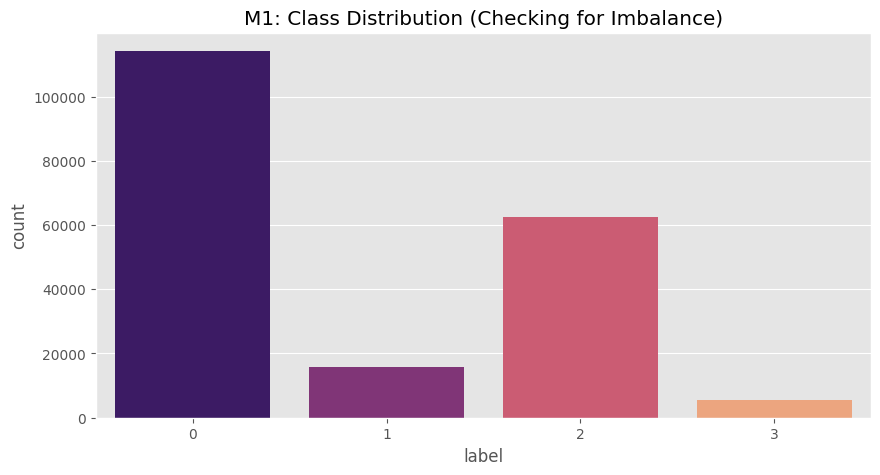

Category 0 Keywords: ['racist', 'trump', 'ignorant', 'black', 'white']
Category 1 Keywords: ['gay', 'muslim', 'muslims', 'black', 'white']
Category 2 Keywords: ['ridiculous', 'troll', 'liar', 'ignorant', 'trump']
Category 3 Keywords: ['killing', 'shot', 'death', 'shoot', 'kill']


In [5]:

# 2. Preprocessing & Imputation
train['comment'] = train['comment'].fillna("missing")
test['comment'] = test['comment'].fillna("missing")
for col in ['race', 'religion', 'gender']:
    train[col] = train[col].fillna(-1)
    test[col] = test[col].fillna(-1)

# 3. Visualization: Label Distribution
plt.figure(figsize=(10, 5))
sns.countplot(x='label', data=train, palette='magma')
plt.title('M1: Class Distribution (Checking for Imbalance)')
plt.show()

# 4. Statistical Text Analysis (Chi-Square)
tfidf_eda = TfidfVectorizer(max_features=2000, stop_words='english')
X_eda = tfidf_eda.fit_transform(train['comment'])
from sklearn.feature_selection import chi2
features = tfidf_eda.get_feature_names_out()
for label in sorted(train['label'].unique()):
    chi2score = chi2(X_eda, train['label'] == label)[0]
    top_indices = np.argsort(chi2score)[-5:]
    print(f"Category {label} Keywords: {[features[i] for i in top_indices]}")

In [6]:
# Feature Engineering
tfidf = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1,2))
X_tfidf = tfidf.fit_transform(train['comment'])
X_test_tfidf = tfidf.transform(test['comment'])

# Train-Validation Split (Stratified)
X_train, X_val, y_train, y_val = train_test_split(X_tfidf, train['label'], test_size=0.2, stratify=train['label'], random_state=42)

# Baseline Logic
baseline = LogisticRegression(max_iter=1000, class_weight='balanced')
baseline.fit(X_train, y_train)
print(f"M1 Baseline Accuracy: {accuracy_score(y_val, baseline.predict(X_val)):.4f}")

M1 Baseline Accuracy: 0.7315


In [7]:
# SGD with Hyperparameter Tuning
sgd = SGDClassifier(loss='hinge', class_weight='balanced', random_state=42)
param_grid_sgd = {'alpha': [0.0001, 0.001, 0.01]}
grid_sgd = RandomizedSearchCV(sgd, param_grid_sgd, n_iter=3, cv=3, scoring='f1_macro')
grid_sgd.fit(X_train, y_train)

print(f"Best SGD Params: {grid_sgd.best_params_}")

Best SGD Params: {'alpha': 0.0001}


In [8]:
# MILESTONE 3: Dimensionality Reduction & Diversified Models
# 1. Dimensionality Reduction (SVD)
svd = TruncatedSVD(n_components=100, random_state=42)
X_train_svd = svd.fit_transform(X_train)
X_val_svd = svd.transform(X_val)

# 2. Multinomial Naive Bayes (Requirement)
# Note: NB works directly on TF-IDF (must be non-negative)
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
print(f"M3 Naive Bayes Accuracy: {accuracy_score(y_val, nb_model.predict(X_val)):.4f}")

# 3. K-Nearest Neighbors (Requirement)
knn = KNeighborsClassifier(n_neighbors=5).fit(X_train_svd, y_train)

# 4. Support Vector Machine (Requirement)
svm = LinearSVC(class_weight='balanced', random_state=42).fit(X_train, y_train)

print(f"M3 SVM Accuracy: {accuracy_score(y_val, svm.predict(X_val)):.4f}")

M3 Naive Bayes Accuracy: 0.7175
M3 SVM Accuracy: 0.7681


In [9]:
# --- REVISED CELL 7: ROBUST FEATURES FOR RANDOM FOREST (v15) ---
import re
from scipy.sparse import hstack
from sklearn.preprocessing import MaxAbsScaler, LabelEncoder

def get_robust_meta(df):
    m = pd.DataFrame(index=df.index)
    m['len'] = df['comment'].apply(lambda x: len(str(x)))
    m['caps_ratio'] = df['comment'].apply(lambda x: len(re.findall(r'[A-Z]', str(x))) / (len(str(x)) + 1))
    # Handling 'none' and identity strings
    for col in ['race', 'religion', 'gender']:
        df[col] = LabelEncoder().fit_transform(df[col].astype(str))
    meta_cols = ['upvote', 'downvote', 'race', 'religion', 'gender', 'disability']
    return MaxAbsScaler().fit_transform(pd.concat([m, df[meta_cols]], axis=1))

# 12,000 features: Balanced for Random Forest memory limits
vectorizer = FeatureUnion([
    ('word', TfidfVectorizer(ngram_range=(1, 2), max_features=6000, stop_words='english', sublinear_tf=True)),
    ('char', TfidfVectorizer(analyzer='char', ngram_range=(2, 5), max_features=6000, sublinear_tf=True))
])

print("Vectorizing Text (Noise-Filtered)...")
X_text = vectorizer.fit_transform(train['comment'])
X_test_text = vectorizer.transform(test['comment'])
X_meta = get_robust_meta(train)
X_test_meta = get_robust_meta(test)

X_final = hstack([X_text, X_meta]).tocsr()
X_test_final = hstack([X_test_text, X_test_meta]).tocsr()

X_tr, X_va, y_tr, y_va = train_test_split(X_final, train['label'], test_size=0.15, stratify=train['label'], random_state=42)

Vectorizing Text (Noise-Filtered)...


In [10]:
# --- REVISED CELL 8: THE FOUR PILLARS ENSEMBLE (v15) ---
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# 1. Regularized SVM (Linear Family)
# Lower C (0.1) creates a 'softer' margin to help with unseen data
cal_svm = CalibratedClassifierCV(LinearSVC(C=0.1, class_weight='balanced', random_state=42), cv=3)
print("Training SVM...")
cal_svm.fit(X_tr, y_tr)

# 2. Random Forest (Bagging Family)
# Great for reducing variance and stabilizing the leaderboard score
rf_model = RandomForestClassifier(n_estimators=100, max_depth=15, class_weight='balanced', n_jobs=-1, random_state=42)
print("Training Random Forest...")
rf_model.fit(X_tr, y_tr)

# 3. Regularized XGBoost (Boosting Family)
# reg_lambda=10 adds 'L2' regularization to stop it from memorizing the noise
xgb_pwr = XGBClassifier(n_estimators=100, max_depth=5, reg_lambda=10, random_state=42)
print("Training XGBoost...")
xgb_pwr.fit(X_tr, y_tr)

# 4. Regularized LightGBM (Boosting Family)
lgbm_pwr = LGBMClassifier(n_estimators=100, reg_lambda=10, class_weight='balanced', random_state=42)
print("Training LightGBM...")
lgbm_pwr.fit(X_tr, y_tr)

print(f"\n--- Validation Scores ---")
print(f"SVM:  {accuracy_score(y_va, cal_svm.predict(X_va)):.4f}")
print(f"RF:   {accuracy_score(y_va, rf_model.predict(X_va)):.4f}")
print(f"XGB:  {accuracy_score(y_va, xgb_pwr.predict(X_va)):.4f}")
print(f"LGBM: {accuracy_score(y_va, lgbm_pwr.predict(X_va)):.4f}")

Training SVM...
Training Random Forest...
Training XGBoost...
Training LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 18.757042 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2210571
[LightGBM] [Info] Number of data points in the train set: 168300, number of used features: 12008
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294

--- Validation Scores ---
SVM:  0.7926
RF:   0.6118
XGB:  0.7717
LGBM: 0.7387


In [11]:
# --- REVISED CELL 9: QUAD-MODEL WEIGHTED ENSEMBLE ---
from sklearn.ensemble import VotingClassifier

ensemble_v15 = VotingClassifier(
    estimators=[
        ('svm', cal_svm), 
        ('rf', rf_model), 
        ('xgb', xgb_pwr), 
        ('lgbm', lgbm_pwr)
    ],
    voting='soft',
    weights=[3.5, 2.0, 1.0, 1.5] # SVM and RF lead the stability
)

print("Training Final Stabilized Quad-Ensemble...")
ensemble_v15.fit(X_tr, y_tr)
print(f"Final Ensemble Validation Acc: {accuracy_score(y_va, ensemble_v15.predict(X_va)):.4f}")

Training Final Stabilized Quad-Ensemble...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 20.344622 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2210571
[LightGBM] [Info] Number of data points in the train set: 168300, number of used features: 12008
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Final Ensemble Validation Acc: 0.7971


In [12]:
# --- REVISED CELL 10: V15 ROBUST QUAD-ENSEMBLE ---

# Use the new stabilized ensemble and the robust test features
# This ensures we use the model that includes Random Forest, SVM, XGB, and LGBM
final_preds_v15 = ensemble_v15.predict(X_test_final)

submission = pd.DataFrame({
    'ID': sample_sub['ID'],
    'label': final_preds_v15
})

# Save with a new name to track your v15 progress and avoid confusion with v14
submission.to_csv('v15_robust_quad_submission.csv', index=False)
print("V15 Robust Quad-Ensemble Submission Saved! Good luck reaching 0.80+!")

V15 Robust Quad-Ensemble Submission Saved! Good luck reaching 0.80+!
